In [20]:
from typing import Optional

import japanize_matplotlib  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from matplotlib.axes import Axes
from numpy.typing import NDArray
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from src.optimizers._ot_utils import compute_nsw_loss, sinkhorn


class NSWLoss(nn.Module):
    def __init__(
        self,
        click_prob: torch.Tensor,
        am_rel: torch.Tensor,
        a: torch.Tensor,
        b: torch.Tensor,
        n_iter: int = 30,
        eps: float = 1,
    ):
        super(NSWLoss, self).__init__()
        self.click_prob = click_prob
        self.am_rel = am_rel
        self.a = a
        self.b = b
        self.n_iter = n_iter
        self.eps = eps

    def forward(self, C: torch.Tensor) -> torch.Tensor:
        X = sinkhorn(C, self.a, self.b, n_iter=self.n_iter, eps=self.eps)
        loss = compute_nsw_loss(X[:, :, :-1], self.click_prob, self.am_rel)
        return loss


def compute_pi_ot_nsw(
    rel_mat: NDArray[np.float_],
    expo: NDArray[np.float_],
    high: NDArray[np.float_],
    alpha: float = 0.0,
    eps: float = 0.01,
    lr: float = 0.01,
    max_iter: int = 200,
    ot_n_iter: int = 30,
    tol: float = 1e-6,
    device: str = "cpu",
    use_amp: Optional[bool] = None,
) -> tuple[NSWLoss, torch.Tensor]:
    """_description_

    Args:
        rel_mat (NDArray[np.float_]): relevance matrix. (n_query, n_doc)
        expo (NDArray[np.float_]): exposure matrix. (n_rank, 1)
        high (NDArray[np.float_]): high matrix. (n_doc, )
        alpha (float, optional): alpha. Defaults to 0.0.
        lr (float, optional): learning rate. Defaults to 0.01.
        ot_n_iter (int, optional): number of iteration for ot. Defaults to 30.
        tol (float, optional): tolerance. Defaults to 1e-6.
        device (str, optional): device. Defaults to "cpu".
        pi_stock_size (int, optional): pi stock size. Defaults to 0.
        grad_stock_size (int, optional): grad stock size. Defaults to 0.

    Returns:
        NDArray[np.float_]: _description_
    """
    n_query, n_doc = rel_mat.shape
    n_rank = expo.shape[0]
    rel_mat: torch.Tensor = torch.FloatTensor(rel_mat).to(device)  # (n_query, n_doc)
    expo: torch.Tensor = torch.FloatTensor(expo).to(device)  # (K, 1)
    am_rel = rel_mat.sum(0) ** alpha  # (n_doc, ), merit for each documnet, alpha nswに利用
    click_prob = rel_mat[:, :, None] * expo.reshape(1, 1, n_rank)  # (n_query, n_doc, K)

    # アイテムからの供給量
    a: torch.Tensor = torch.FloatTensor(high).view(1, -1, 1).to(device)
    # ダミー列への輸送量はアイテム数 - 表示数
    dummy_demand = a.sum(dim=1) - n_rank  # (n_query, 1)
    b = torch.ones(n_query, n_rank + 1, 1, device=device)
    b[:, -1, :] = dummy_demand

    # 初期値は一様分布
    # 表示数 < アイテム数の場合にはダミー列に輸送されるようにする
    C = nn.Parameter(torch.ones(n_query, n_doc, n_rank + 1).to(device))
    optimier = torch.optim.Adam([C], lr=lr)
    loss_fn = NSWLoss(click_prob, am_rel, a, b, n_iter=ot_n_iter, eps=eps)
    if use_amp is None:
        use_amp = True if device == "cuda" else False
    scaler = GradScaler(enabled=use_amp)
    for _ in tqdm(range(max_iter), leave=False):
        optimier.zero_grad()
        with autocast(enabled=use_amp):
            # compute X
            loss = loss_fn(C)
        scaler.scale(loss).backward()
        scaler.step(optimier)
        scaler.update()

        grad_norm = torch.norm(C.grad)
        # 勾配を記録
        # gradient normが一定以下になったら終了
        if grad_norm < tol:
            break

    return loss_fn, C.detach()

In [21]:
def calulate_loss_landscape(
    loss_fn: NSWLoss,
    C: torch.Tensor,
    x_direrction: torch.Tensor,
    y_direrction: torch.Tensor,
    interval: int = 5,
    num: int = 50,
) -> tuple[NDArray[np.float_], NDArray[np.float_], NDArray[np.float_]]:
    init_C = C.clone().detach()
    xcoordinates = np.linspace(-interval, interval, num)
    ycoordinates = np.linspace(-interval, interval, num)
    losses = -np.ones(shape=(len(xcoordinates), len(ycoordinates)))
    inds, coords = get_indices(losses, xcoordinates, ycoordinates)

    for count, ind in enumerate(tqdm(inds)):
        coord = coords[count]

        # update weights
        change = x_direrction * coord[0] + y_direrction * coord[1]
        C_i = init_C + torch.Tensor(change).to(init_C.device)
        loss = loss_fn(C_i)

        losses.ravel()[ind] = loss.item()

    X, Y = np.meshgrid(xcoordinates, ycoordinates)
    return X, Y, losses


def get_indices(
    vals: NDArray[np.float_], xcoordinates: NDArray[np.float_], ycoordinates: NDArray[np.float_]
) -> tuple[NDArray[np.int_], NDArray[np.float_]]:
    inds = np.array(range(vals.size))
    inds = inds[vals.ravel() <= 0]

    xcoord_mesh, ycoord_mesh = np.meshgrid(xcoordinates, ycoordinates)
    s1 = xcoord_mesh.ravel()[inds]
    s2 = ycoord_mesh.ravel()[inds]

    return inds, np.c_[s1, s2]

In [22]:
from src import create_generator


def visualize_loss_landscape(
    n_query: int, n_doc: int, K: int, interval: int = 5, num: int = 50
) -> None:
    g = create_generator("synthetic", n_query=n_query, n_doc=n_doc)
    _, rel_mat_obs = g.generate_rel_mat()
    expo = g.exam_func(K=K)
    high = np.ones(rel_mat_obs.shape[1])
    device = "cuda"

    loss_fn, C = compute_pi_ot_nsw(
        rel_mat_obs, expo, high=high, lr=0.1, eps=1, device=device, use_amp=False, tol=0.01
    )

    # get random direction
    x_direrction = torch.randn(C.size()).to(C.device)
    y_direrction = torch.randn(C.size()).to(C.device)
    # normalize direction
    x_direrction.mul_(C.norm() / (x_direrction.norm() + 1e-10))
    y_direrction.mul_(C.norm() / (y_direrction.norm() + 1e-10))

    # calculate loss landscape
    X, Y, Z = calulate_loss_landscape(loss_fn, C, x_direrction, y_direrction, interval, num)

    # plot loss landscape
    fig = plt.figure()
    ax: Axes = fig.add_subplot(111, projection="3d")
    ax.plot_surface(X, Y, Z, cmap="viridis")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("loss")
    ax.set_title(f"Loss Landscape (n_query={n_query}, n_doc={n_doc}, K={K})")
    fig.tight_layout()

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 2500/2500 [00:01<00:00, 2093.50it/s]


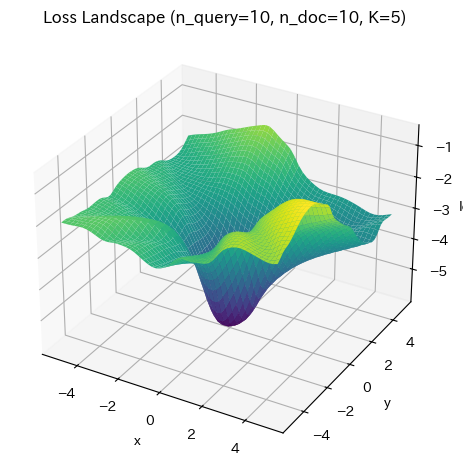

In [23]:
visualize_loss_landscape(n_query=10, n_doc=10, K=5)

100%|██████████| 2500/2500 [00:01<00:00, 2053.16it/s]


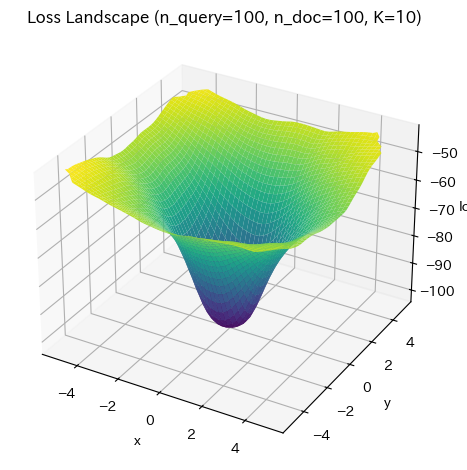

In [24]:
visualize_loss_landscape(n_query=100, n_doc=100, K=10)

100%|██████████| 2500/2500 [00:02<00:00, 1146.70it/s]


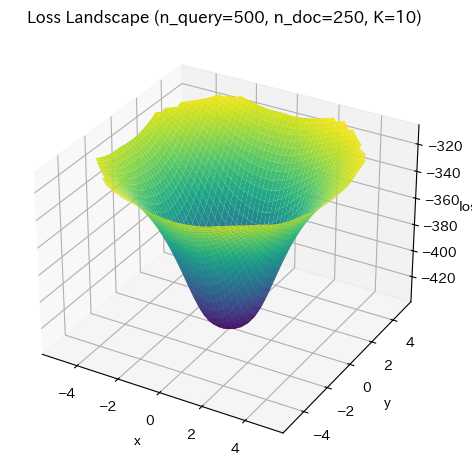

In [25]:
visualize_loss_landscape(n_query=500, n_doc=250, K=10)